# Bank Marketing Classification with Cost-Based Thresholding
This notebook combines the study of bank marketing classification models with cost-based thresholding evaluation

## 1. Import Libraries and Load Data
Every project has its own dependancies. Libraries, settings, tools they all serve a purpose and its good practise to add this at a centralized place within the code. There is no better place than the starting section of a project.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# necesarry for exporting the model
import pickle
import os

## 2. Load Data
As mentioned in Geron importing data with a function is a good practise.
By adding this functionality, it makes the code easier to refactor into production

In [2]:
# Loading with function for easy maintanance later on (best practices as Geron discussed)
def getDataSet():
    return pd.read_csv("bank-additional-full.csv", sep=';')

# Load dataset
df = getDataSet()

## 2. Preprocess Data
Preprocessing data is necesarry as it makes the dataset more readable and usable for models. Some values have little to no meaning in their original form, but preprocessing enables the data to have meaning. Mapping of values, removing data that is lacking or one-hot encoding all happens here

In [3]:
# Drop duration (not known before call is made)
df.drop(columns=['duration'], inplace=True)

# Encode target variable
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Handle categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].replace('unknown', np.nan)
for col in categorical_cols:
   df[col].fillna(df[col].mode()[0], inplace=True)

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Train-test split
X = df_encoded.drop(columns=['y'])
y = df_encoded['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {y.value_counts(normalize=True)}")

Dataset shape: (41188, 20)
Target distribution: y
0    0.887346
1    0.112654
Name: proportion, dtype: float64


## 3. Feature Selection
This code sets up a feature selection pipeline using Recursive Feature Elimination (RFE) with a logistic regression model. The LogisticRegression is configured with the 'liblinear' solver and a maximum of 1000 iterations, and RFE will iteratively remove features one at a time (step=1) until only the top 20 most important features (n_features_to_select=20) remain.

In [4]:
# Feature selection using RFE
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
selector = RFE(estimator=lr_model, n_features_to_select=20, step=1)
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.support_]

# Prepare reduced feature set
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

print(f"Selected features ({len(selected_features)}): {list(selected_features)}")

Selected features (20): ['previous', 'euribor3m', 'job_blue-collar', 'job_retired', 'job_services', 'job_student', 'education_basic.9y', 'education_university.degree', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_oct', 'day_of_week_mon', 'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success']


## 4. Define Cost-Based Thresholding Functions
This code implements an empirical cost-based thresholding method for binary classification, which identifies the optimal decision threshold that minimizes the expected cost of false positives and false negatives, given their respective costs (C_FP, C_FN). It calculates true positives, false positives, and false negatives across possible thresholds and plots the total cost as a function of threshold. The function also prints key performance metrics at the optimal threshold and optionally compares it with a threshold derived from cost-based probability calibration.

In [5]:
def binary_clf_curve(y_true, y_score):
    """Calculate thresholds as well as true and false positives and false negatives per threshold."""
    
    # Ensure both inputs are NumPy arrays
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # extract thresholds
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # compute metrics
    tps = np.cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    fns = tps[-1] - tps
    thresholds = y_score[threshold_idxs]
    
    return tps, fps, fns, thresholds

In [6]:
def empirical_costbased_thresholding(y_true, scores, model_name, C_FP, C_FN, p=False):
    """
    Illustrates Empirical Cost-Based Thresholding
    """
    
    true_positives, false_positives, false_negatives, thresholds = binary_clf_curve(y_true, scores)
    
    total_costs = C_FP * false_positives + C_FN * false_negatives  
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(thresholds, total_costs, marker='o', color='blue', linestyle='-', alpha=0.6)
    plt.plot(thresholds, total_costs, linestyle='-', color='blue', linewidth=4, label='Total Expected Cost')
    
    if(p):
        plt.xlabel("Probability Threshold", fontsize=12)
    else:
        plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Cost", fontsize=12)
    plt.title(f"Cost vs. Threshold - {model_name}", fontsize=14)
    
    min_cost_index = np.argmin(total_costs)
    optimal_threshold = thresholds[min_cost_index]
    
    plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    TP = true_positives[min_cost_index]
    FP = false_positives[min_cost_index]
    FN = false_negatives[min_cost_index]
    TN = len(y_true) - TP - FP - FN
    precision = TP/(TP+FP) if (TP+FP) > 0 else 0
    recall = TP/(TP+FN) if (TP+FN) > 0 else 0
    
    threshold_with_calibrated_p = C_FP/(C_FN+C_FP)
    
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    print(f"Optimal threshold: {optimal_threshold:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"Empirically minimized expected costs: {total_costs[min_cost_index]:.2f}")
    
    if(p):
        print(f"\nWith calibrated p threshold would be: {threshold_with_calibrated_p:.3f}")
        index = np.searchsorted(-thresholds, -threshold_with_calibrated_p, side='right') - 1
        if 0 <= index < len(total_costs):
            print(f"Expected cost with calibrated p threshold: {total_costs[index]:.2f}")
    
    return {
        'optimal_threshold': optimal_threshold,
        'min_cost': total_costs[min_cost_index],
        'precision': precision,
        'recall': recall,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN
    }

## 5. Define and Train Models
This code trains multiple classification models on selected training features and stores their predicted probabilities on the test set for comparison and evaluation. It also returns when a model is finished as it can take some time without proper feedback when running.

In [7]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(6,), max_iter=100, random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Train models and store predictions
model_predictions = {}
model_objects = {}

for name, model in models.items():
    model.fit(X_train_sel, y_train)
    y_pred_prob = model.predict_proba(X_test_sel)[:, 1]
    model_predictions[name] = y_pred_prob
    model_objects[name] = model
    print(f"Trained: {name}")

Trained: Logistic Regression
Trained: Decision Tree
Trained: Neural Network (MLP)
Trained: Support Vector Machine
Trained: Random Forest
Trained: Gradient Boosting
Trained: Naive Bayes
Trained: XGBoost


## 6. Traditional Model Evaluation - ROC Curves
In the original Moro et al. study the models where evaluated with ROC curves, so I do that here as well.
Results are printed out to see, of course I add the visuals

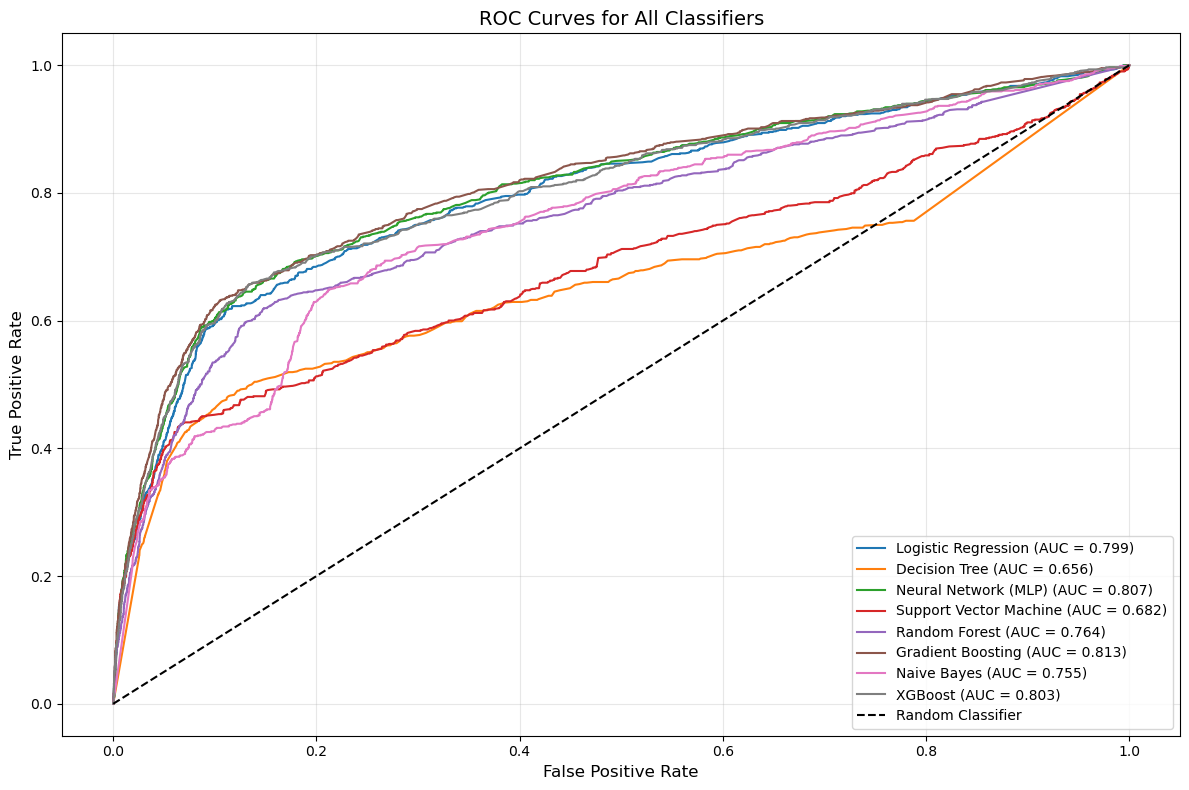


AUC Scores:
Gradient Boosting: 0.813
Neural Network (MLP): 0.807
XGBoost: 0.803
Logistic Regression: 0.799
Random Forest: 0.764
Naive Bayes: 0.755
Support Vector Machine: 0.682
Decision Tree: 0.656


In [8]:
# Evaluate models with ROC curves
auc_scores = {}
plt.figure(figsize=(12, 8))

for name, y_pred_prob in model_predictions.items():
    auc = roc_auc_score(y_test, y_pred_prob)
    auc_scores[name] = auc
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Plot ROC curves
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves for All Classifiers", fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display AUC scores
print("\nAUC Scores:")
for model, auc in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {auc:.3f}")

## 7. Lift Curve Analysis
In the original Moro et al. study the models where also evaluated with Lift curves, so I do that here as well
Results are printed out to see, of course I add the visuals

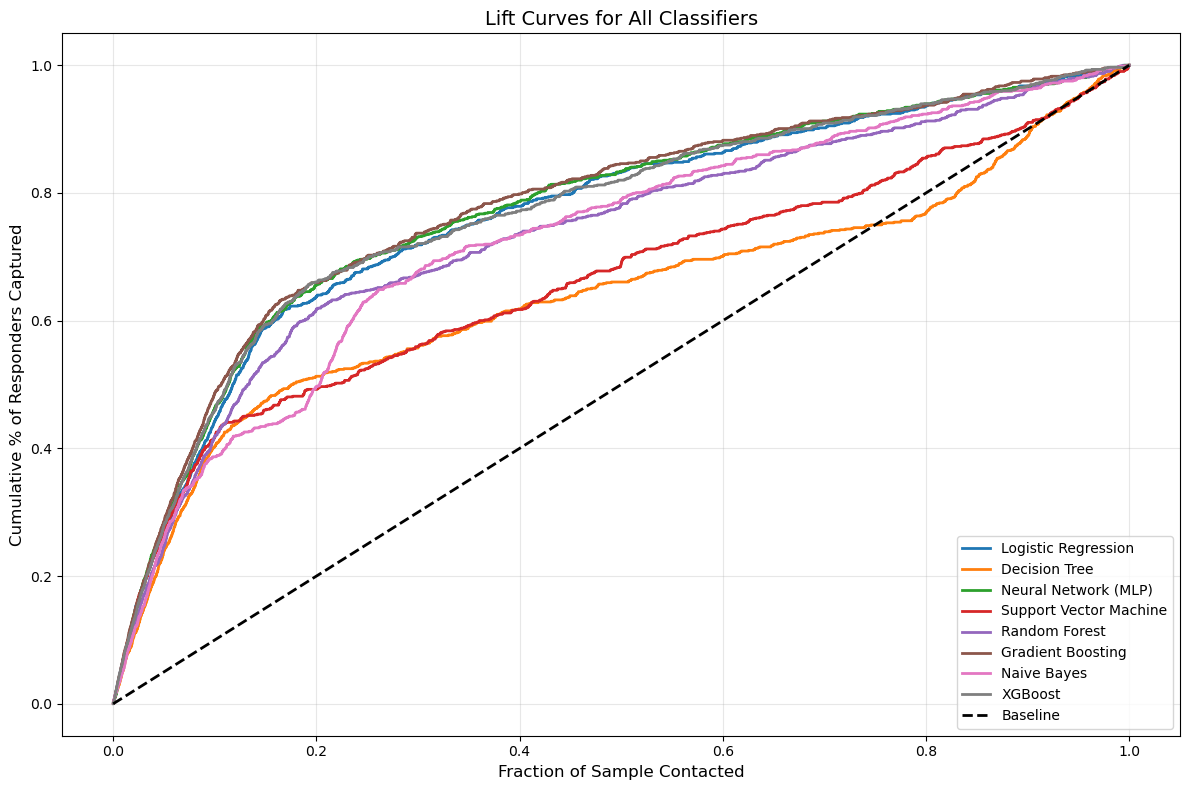

In [9]:
def plot_lift_curve(y_true, y_scores, label, ax=None):
    df_lift = pd.DataFrame({'y_true': y_true, 'y_scores': y_scores})
    df_lift = df_lift.sort_values('y_scores', ascending=False)
    df_lift['cum_positives'] = df_lift['y_true'].cumsum()
    df_lift['lift'] = df_lift['cum_positives'] / df_lift['y_true'].sum()
    df_lift['percentile'] = np.arange(1, len(df_lift) + 1) / len(df_lift)

    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(df_lift['percentile'], df_lift['lift'], label=label, linewidth=2)
    return ax

# Plot lift curves
fig, ax = plt.subplots(figsize=(12, 8))

for name, probs in model_predictions.items():
    plot_lift_curve(y_test, probs, label=name, ax=ax)

ax.plot([0, 1], [0, 1], 'k--', label="Baseline", linewidth=2)
ax.set_xlabel("Fraction of Sample Contacted", fontsize=12)
ax.set_ylabel("Cumulative % of Responders Captured", fontsize=12)
ax.set_title("Lift Curves for All Classifiers", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 8. Cost-Based Thresholding Analysis
### Define Cost Parameters for Strategy Context
To provide scenario based cost evaluation different strategies are created:

Scenario 1: Conservative - Missing potential customers is more costly
Scenario 2: Balanced
Scenario 3: Aggressive - Making unnecessary calls is more costly

In [10]:
# Define cost parameters for bank marketing context
# C_FP: Cost of calling someone who won't subscribe (wasted call)
# C_FN: Cost of not calling someone who would have subscribed (lost opportunity)

# Scenario 1: Conservative - Missing potential customers is more costly
C_FP_conservative = 1   # Cost of unnecessary call
C_FN_conservative = 10  # Cost of missed opportunity

# Scenario 2: Balanced
C_FP_balanced = 1
C_FN_balanced = 5

# Scenario 3: Aggressive - Making unnecessary calls is more costly
C_FP_aggressive = 2
C_FN_aggressive = 1

scenarios = [
    ("Conservative", C_FP_conservative, C_FN_conservative),
    ("Balanced", C_FP_balanced, C_FN_balanced),
    ("Aggressive", C_FP_aggressive, C_FN_aggressive)
]

In [11]:
def sanitize_scores(scores, model_name="model"):
    """
    Ensure scores is a 1D array-like of floats.
    - If DataFrame with one column: squeeze to Series
    - If DataFrame with >1 columns: error
    - If ndarray with >1 dims: ravel to 1D
    - Otherwise: convert to numpy array
    """
    # DataFrame
    if isinstance(scores, pd.DataFrame):
        if scores.shape[1] == 1:
            return scores.iloc[:, 0]
        else:
            raise ValueError(
                f"{model_name}: Expected scores DataFrame with 1 column, "
                f"but got {scores.shape[1]} columns."
            )
    # Series: OK as-is
    if isinstance(scores, pd.Series):
        return scores

    # NumPy array
    if isinstance(scores, np.ndarray):
        if scores.ndim > 1:
            return scores.ravel()
        return scores

    # Other array-like (e.g., list)
    arr = np.array(scores)
    if arr.ndim > 1:
        arr = arr.ravel()
    return arr


## 9. Apply Cost-Based Thresholding to All Models
This code evaluates all trained models across multiple cost scenarios by applying an empirical cost-based thresholding method, kindly donated by Wim, to determine the optimal classification threshold for each model-scenario combination, taking into account the specific costs of false positives and false negatives. It prints results for each scenario and stores the detailed performance metrics in a structured dictionary for further analysis.


SCENARIO: Conservative (C_FP=1, C_FN=10)


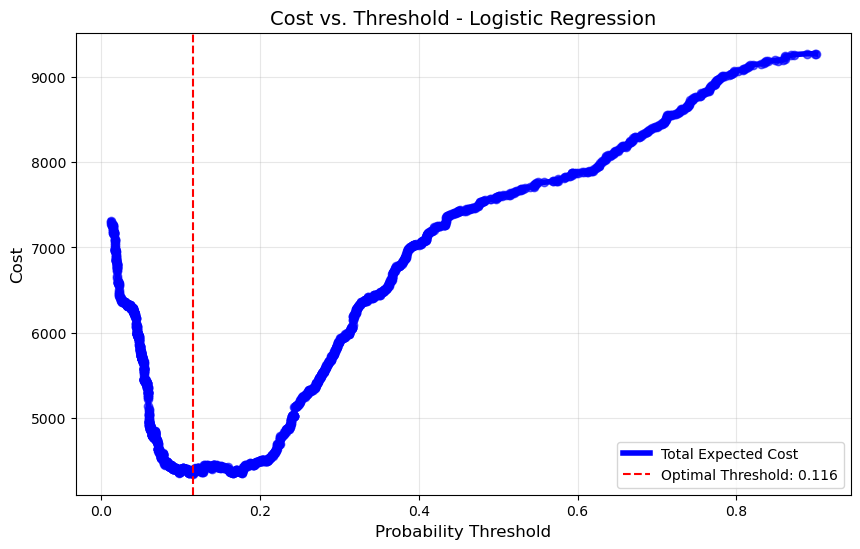


Model: Logistic Regression
Optimal threshold: 0.116
Precision: 0.319
Recall: 0.676
Empirically minimized expected costs: 4347.00

With calibrated p threshold would be: 0.091
Expected cost with calibrated p threshold: 4407.00


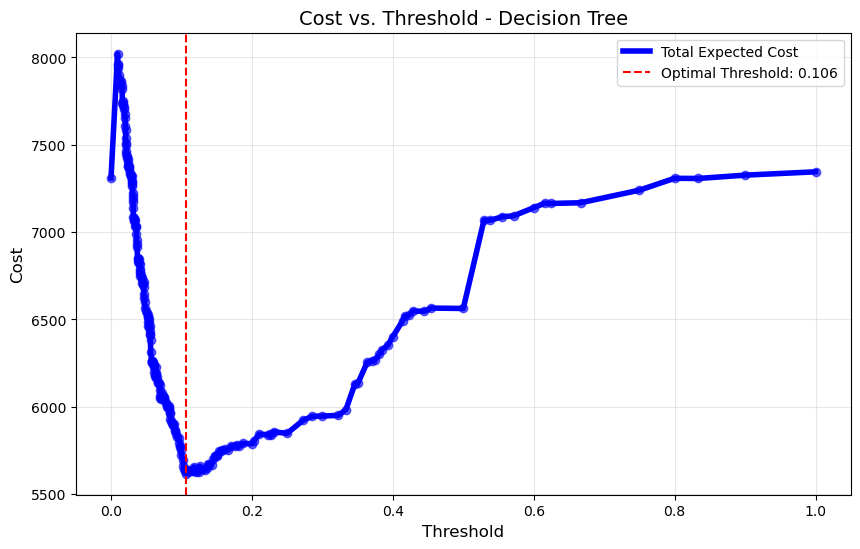


Model: Decision Tree
Optimal threshold: 0.106
Precision: 0.315
Recall: 0.504
Empirically minimized expected costs: 5617.00


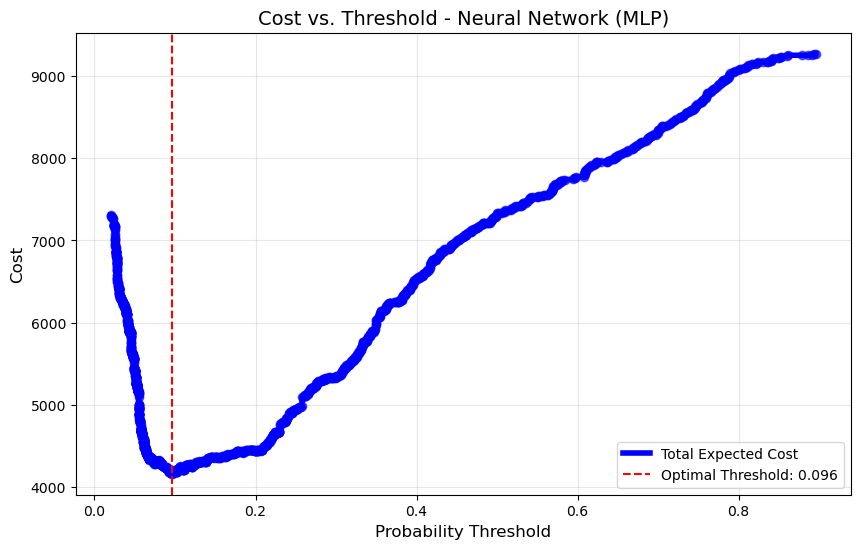


Model: Neural Network (MLP)
Optimal threshold: 0.096
Precision: 0.329
Recall: 0.693
Empirically minimized expected costs: 4163.00

With calibrated p threshold would be: 0.091
Expected cost with calibrated p threshold: 4221.00


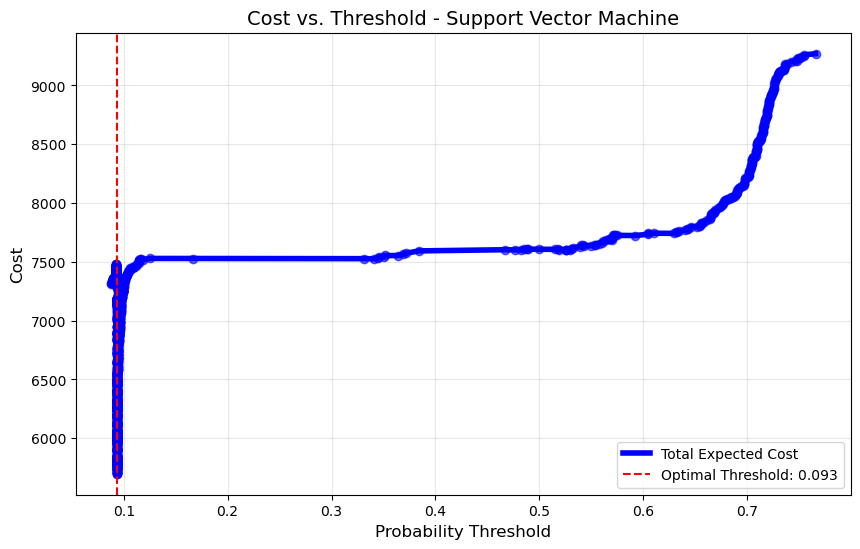


Model: Support Vector Machine
Optimal threshold: 0.093
Precision: 0.446
Recall: 0.441
Empirically minimized expected costs: 5698.00

With calibrated p threshold would be: 0.091
Expected cost with calibrated p threshold: 7355.00


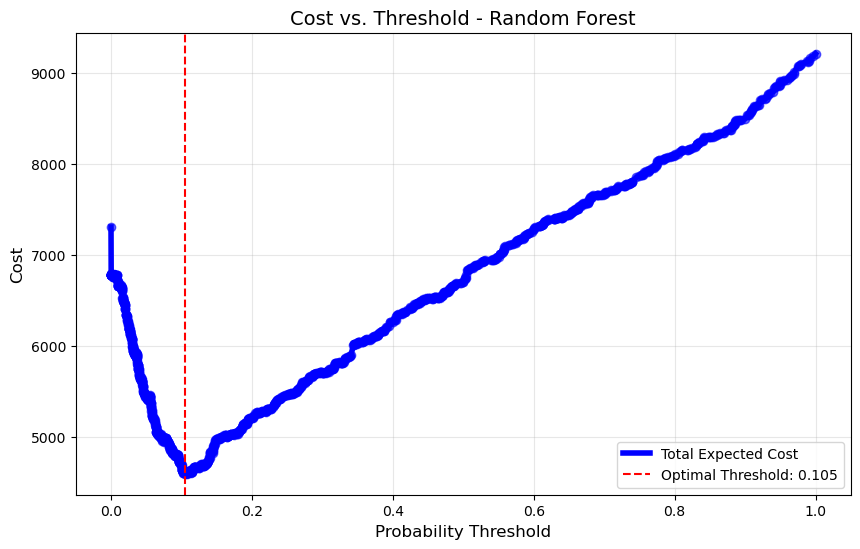


Model: Random Forest
Optimal threshold: 0.105
Precision: 0.330
Recall: 0.633
Empirically minimized expected costs: 4601.00

With calibrated p threshold would be: 0.091
Expected cost with calibrated p threshold: 4801.00


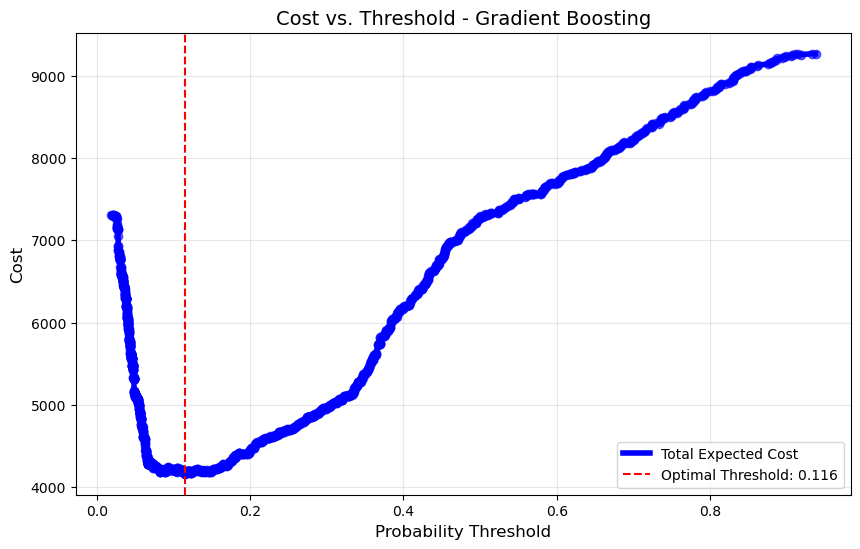


Model: Gradient Boosting
Optimal threshold: 0.116
Precision: 0.383
Recall: 0.657
Empirically minimized expected costs: 4161.00

With calibrated p threshold would be: 0.091
Expected cost with calibrated p threshold: 4215.00


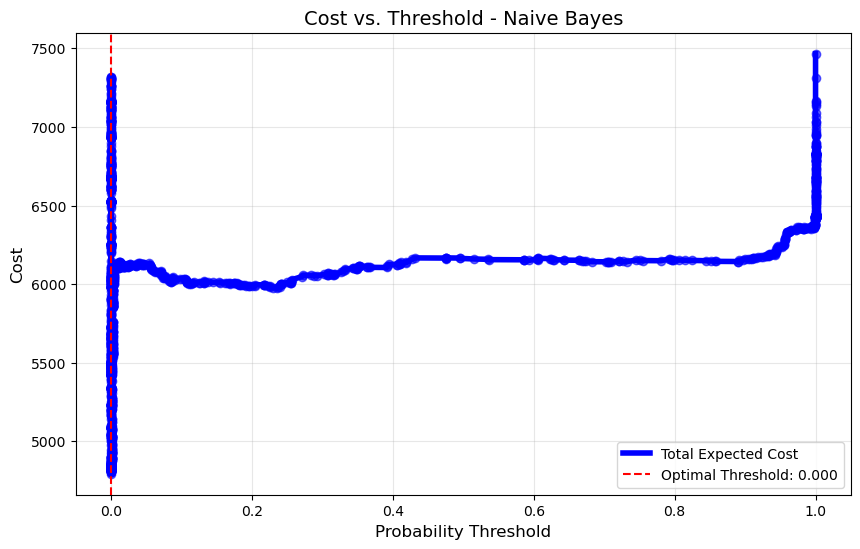


Model: Naive Bayes
Optimal threshold: 0.000
Precision: 0.248
Recall: 0.694
Empirically minimized expected costs: 4794.00

With calibrated p threshold would be: 0.091
Expected cost with calibrated p threshold: 6035.00


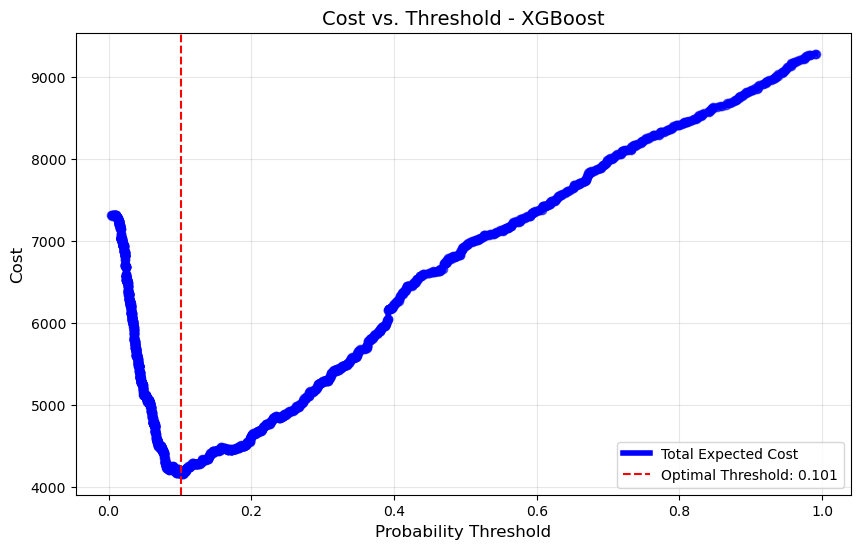


Model: XGBoost
Optimal threshold: 0.101
Precision: 0.380
Recall: 0.659
Empirically minimized expected costs: 4160.00

With calibrated p threshold would be: 0.091
Expected cost with calibrated p threshold: 4239.00

SCENARIO: Balanced (C_FP=1, C_FN=5)


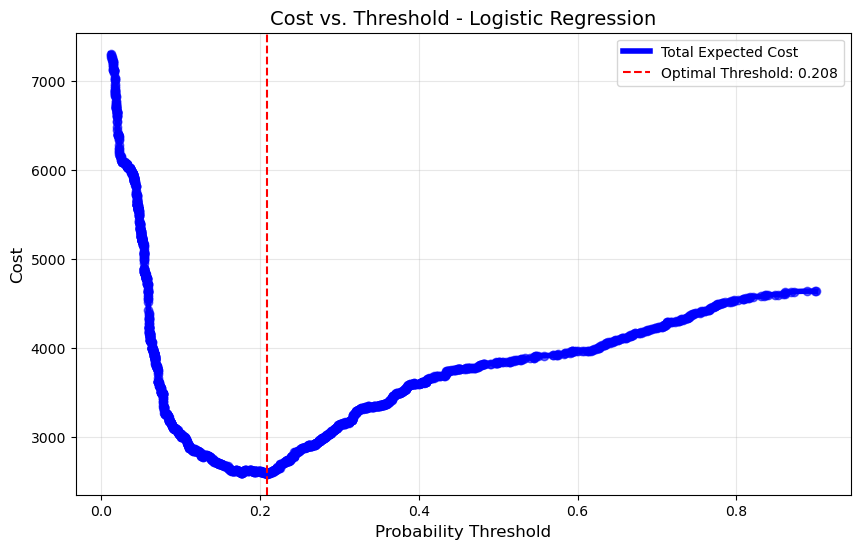


Model: Logistic Regression
Optimal threshold: 0.208
Precision: 0.450
Recall: 0.587
Empirically minimized expected costs: 2581.00

With calibrated p threshold would be: 0.167
Expected cost with calibrated p threshold: 2612.00


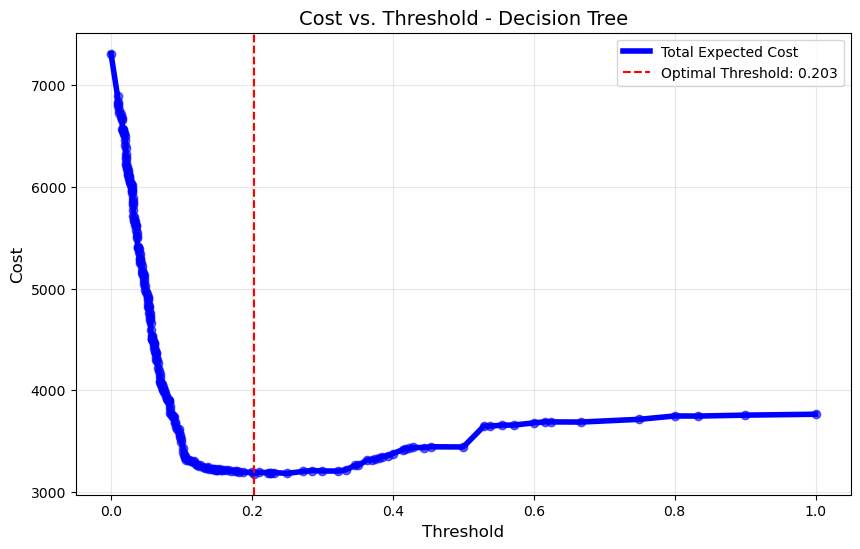


Model: Decision Tree
Optimal threshold: 0.203
Precision: 0.421
Recall: 0.434
Empirically minimized expected costs: 3180.00


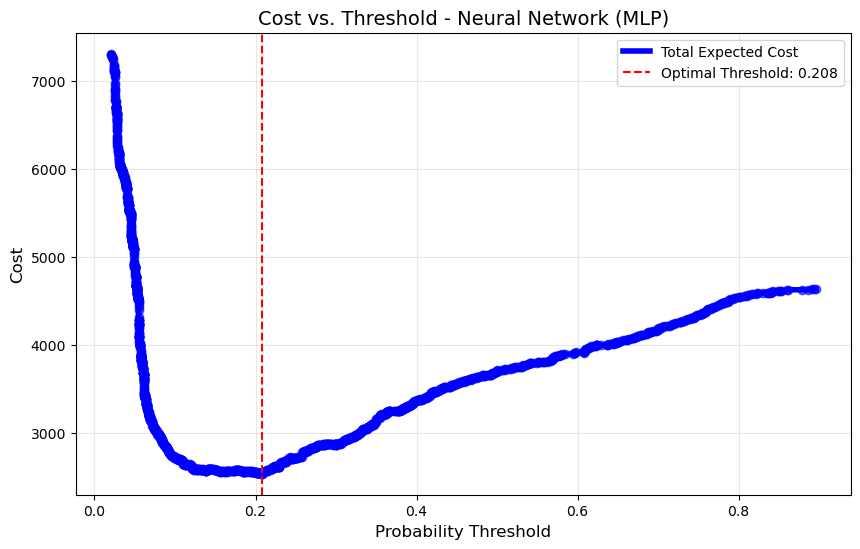


Model: Neural Network (MLP)
Optimal threshold: 0.208
Precision: 0.465
Recall: 0.588
Empirically minimized expected costs: 2537.00

With calibrated p threshold would be: 0.167
Expected cost with calibrated p threshold: 2568.00


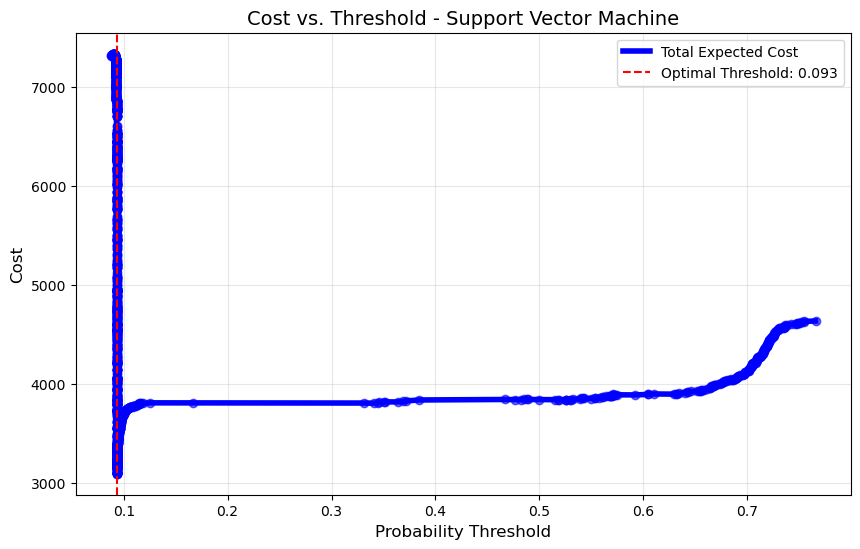


Model: Support Vector Machine
Optimal threshold: 0.093
Precision: 0.454
Recall: 0.439
Empirically minimized expected costs: 3094.00

With calibrated p threshold would be: 0.167
Expected cost with calibrated p threshold: 3807.00


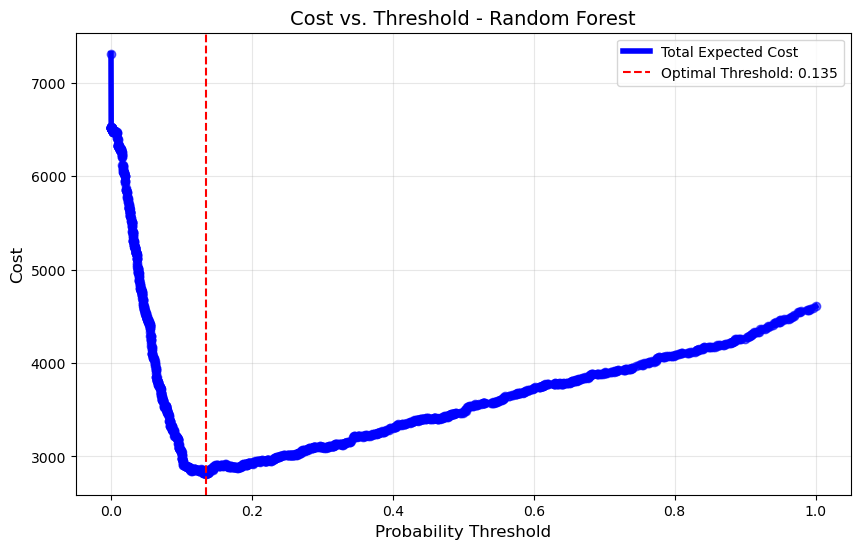


Model: Random Forest
Optimal threshold: 0.135
Precision: 0.374
Recall: 0.592
Empirically minimized expected costs: 2815.00

With calibrated p threshold would be: 0.167
Expected cost with calibrated p threshold: 2892.00


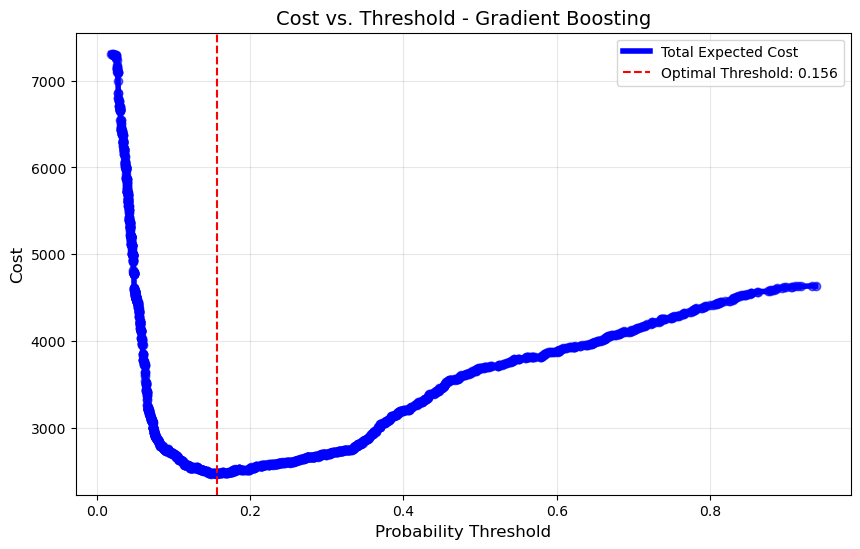


Model: Gradient Boosting
Optimal threshold: 0.156
Precision: 0.442
Recall: 0.625
Empirically minimized expected costs: 2473.00

With calibrated p threshold would be: 0.167
Expected cost with calibrated p threshold: 2485.00


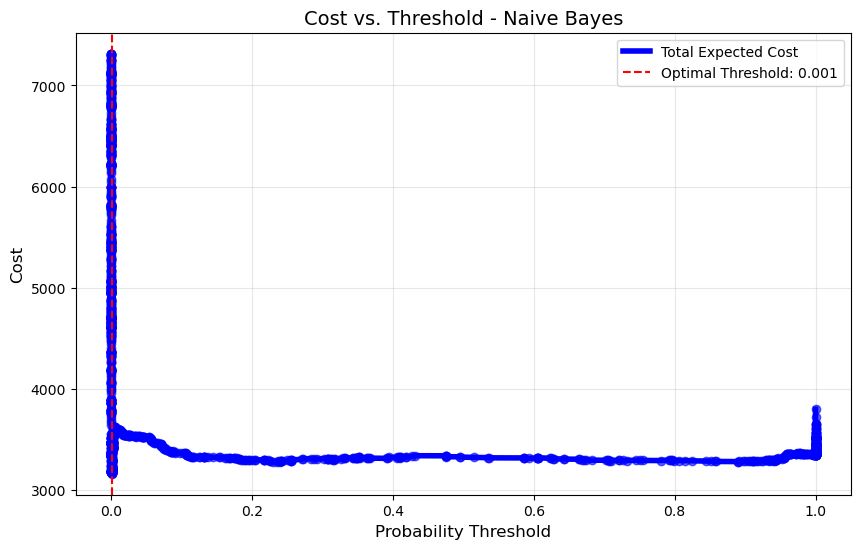


Model: Naive Bayes
Optimal threshold: 0.001
Precision: 0.288
Recall: 0.629
Empirically minimized expected costs: 3164.00

With calibrated p threshold would be: 0.167
Expected cost with calibrated p threshold: 3322.00


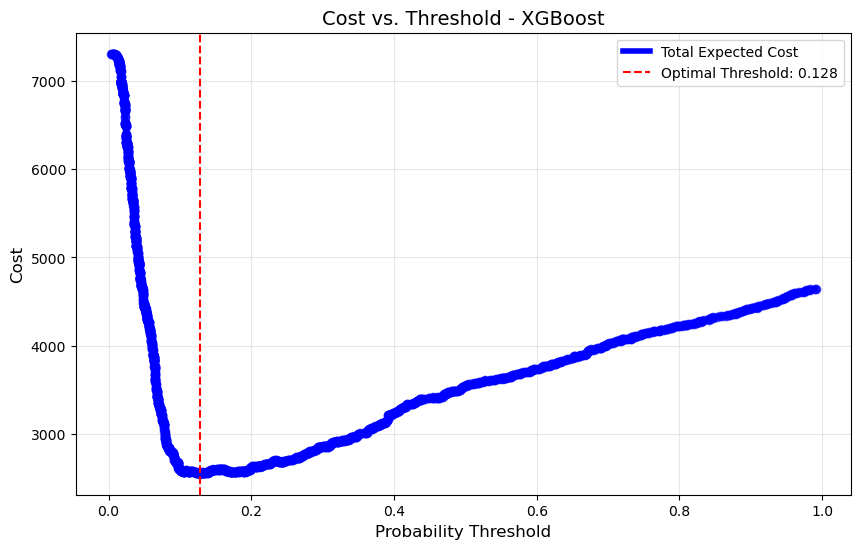


Model: XGBoost
Optimal threshold: 0.128
Precision: 0.416
Recall: 0.627
Empirically minimized expected costs: 2547.00

With calibrated p threshold would be: 0.167
Expected cost with calibrated p threshold: 2575.00

SCENARIO: Aggressive (C_FP=2, C_FN=1)


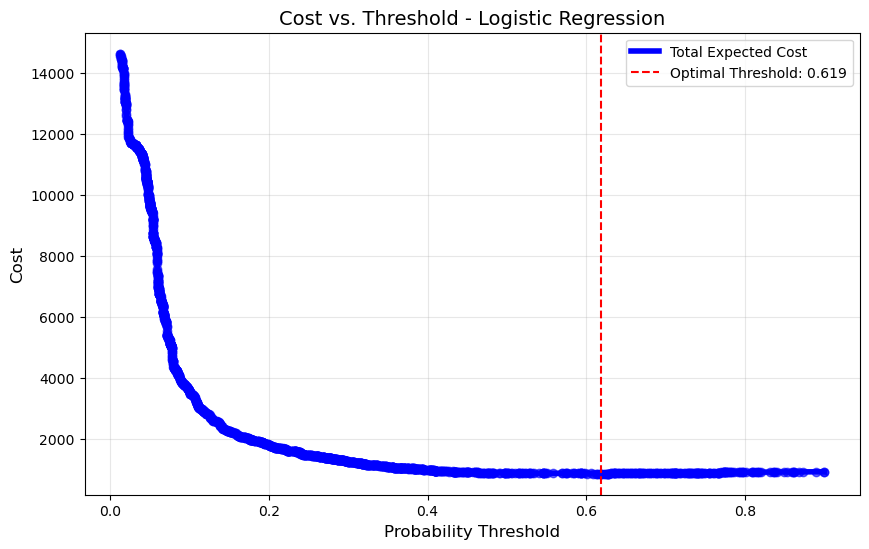


Model: Logistic Regression
Optimal threshold: 0.619
Precision: 0.776
Recall: 0.153
Empirically minimized expected costs: 868.00

With calibrated p threshold would be: 0.667
Expected cost with calibrated p threshold: 883.00


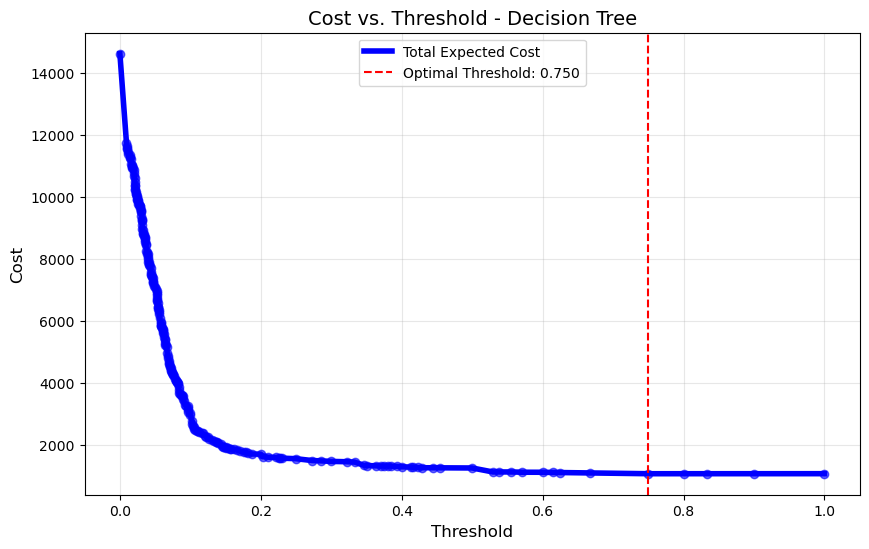


Model: Decision Tree
Optimal threshold: 0.750
Precision: 0.540
Recall: 0.240
Empirically minimized expected costs: 1085.00


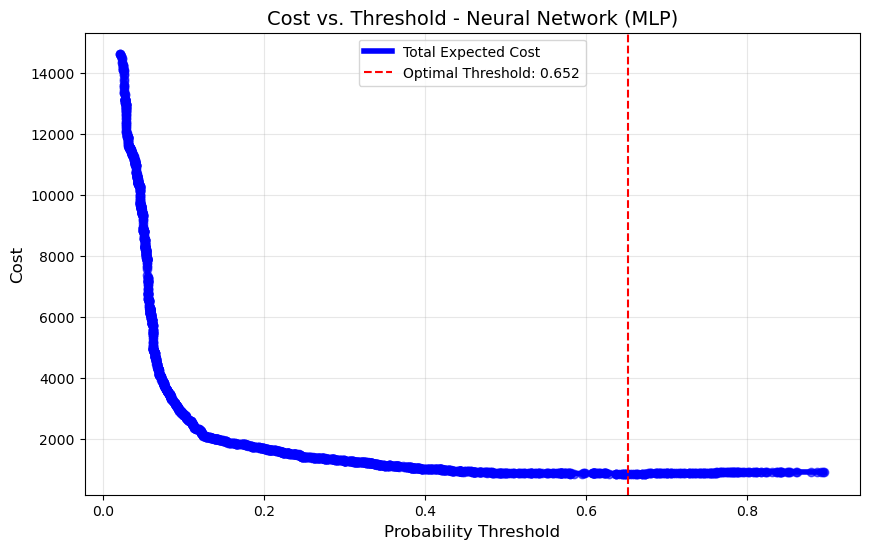


Model: Neural Network (MLP)
Optimal threshold: 0.652
Precision: 0.780
Recall: 0.138
Empirically minimized expected costs: 872.00

With calibrated p threshold would be: 0.667
Expected cost with calibrated p threshold: 878.00


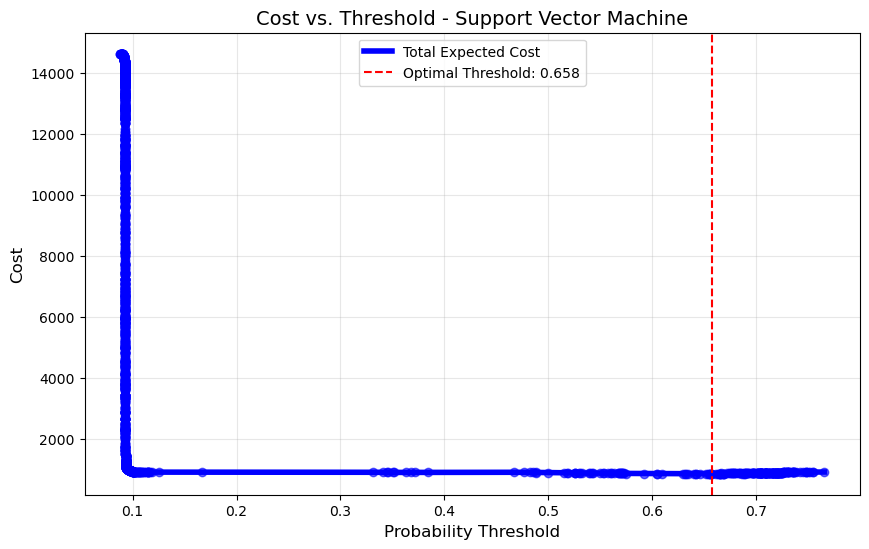


Model: Support Vector Machine
Optimal threshold: 0.658
Precision: 0.764
Recall: 0.161
Empirically minimized expected costs: 871.00

With calibrated p threshold would be: 0.667
Expected cost with calibrated p threshold: 877.00


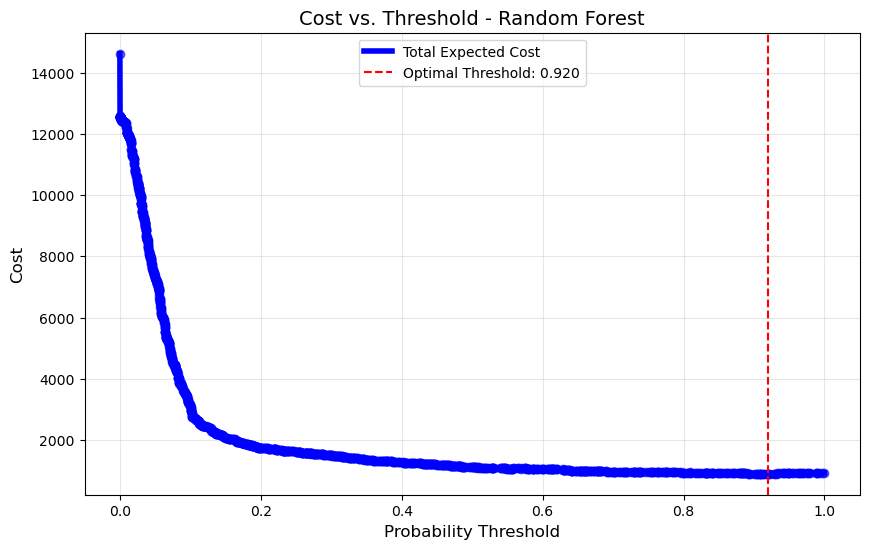


Model: Random Forest
Optimal threshold: 0.920
Precision: 0.783
Recall: 0.070
Empirically minimized expected costs: 899.00

With calibrated p threshold would be: 0.667
Expected cost with calibrated p threshold: 981.00


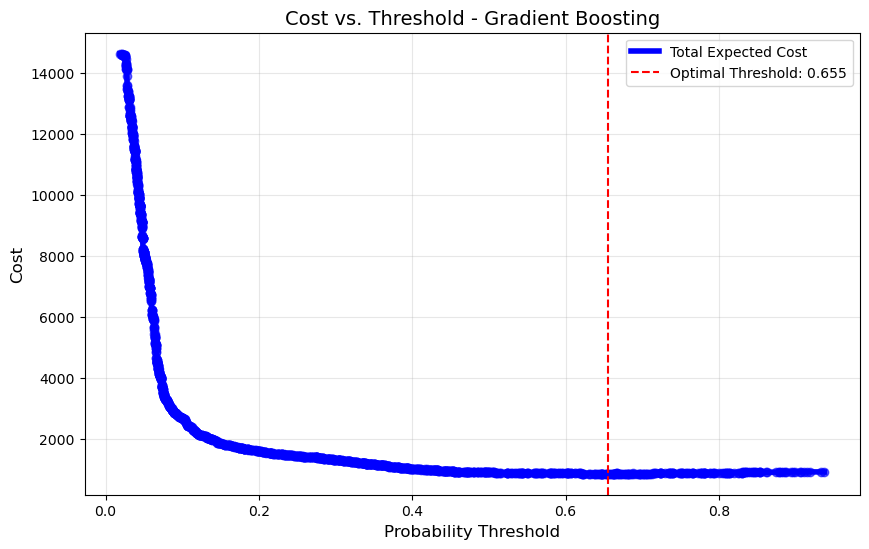


Model: Gradient Boosting
Optimal threshold: 0.655
Precision: 0.777
Recall: 0.147
Empirically minimized expected costs: 870.00

With calibrated p threshold would be: 0.667
Expected cost with calibrated p threshold: 878.00


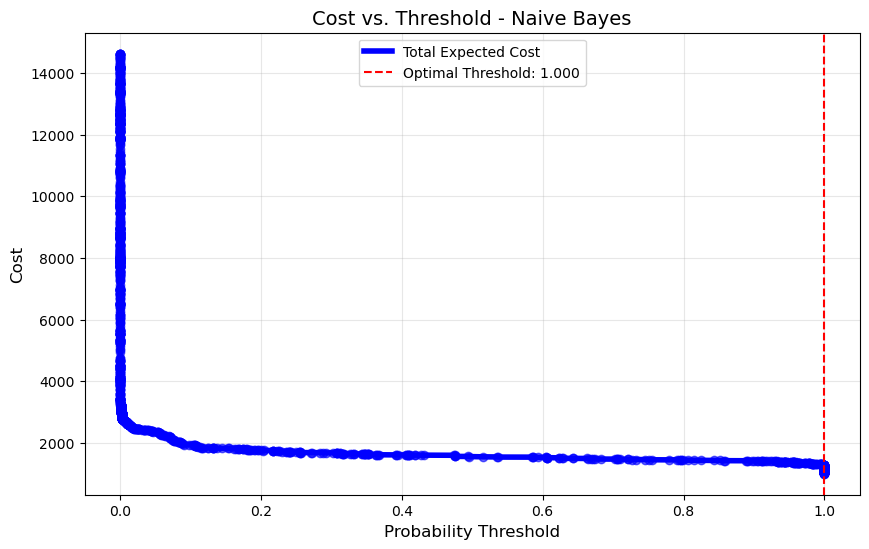


Model: Naive Bayes
Optimal threshold: 1.000
Precision: 0.599
Recall: 0.227
Empirically minimized expected costs: 999.00

With calibrated p threshold would be: 0.667
Expected cost with calibrated p threshold: 1487.00


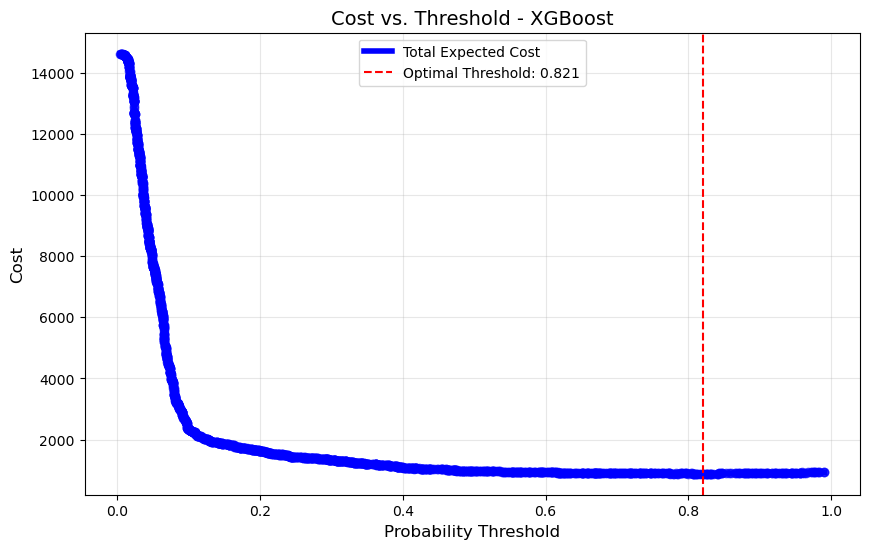


Model: XGBoost
Optimal threshold: 0.821
Precision: 0.804
Recall: 0.088
Empirically minimized expected costs: 886.00

With calibrated p threshold would be: 0.667
Expected cost with calibrated p threshold: 906.00


In [12]:
# Store results for all models and scenarios
cost_results = {}

# loop thru all models n scenarios
for scenario_name, C_FP, C_FN in scenarios:

    # print out some nice header like thingy
    print(f"\n{'='*60}")
    print(f"SCENARIO: {scenario_name} (C_FP={C_FP}, C_FN={C_FN})")
    print(f"{'='*60}")

    # placeholder for scenario data
    scenario_results = {}

    # loop thru models and apply empirical_costbased_thresholding
    for model_name, predictions in model_predictions.items():

        # ensure that scores are 1d arrays
        preds = sanitize_scores(predictions, model_name)
        
        # Check if model outputs probabilities
        is_prob = model_name in ["Logistic Regression", "Neural Network (MLP)", 
                                 "Random Forest", "Gradient Boosting", "Naive Bayes", 
                                 "XGBoost", "Support Vector Machine"]

        # finally I'm gonna use Wim's method, with a little tweak on the numpy arrays
        results = empirical_costbased_thresholding(
            y_test, preds, model_name, C_FP, C_FN, p=is_prob
        )

        # log the results with their respective model name
        scenario_results[model_name] = results
    
    cost_results[scenario_name] = scenario_results

## 10. Comparative Analysis - Cost Summary
After all this, comparing is key, each model is ranked within one of the three scenarios

In [13]:
# Create summary DataFrame
summary_data = []

for scenario_name, scenario_results in cost_results.items():
    for model_name, results in scenario_results.items():
        summary_data.append({
            'Scenario': scenario_name,
            'Model': model_name,
            'Min Cost': results['min_cost'],
            'Optimal Threshold': results['optimal_threshold'],
            'Precision': results['precision'],
            'Recall': results['recall']
        })

summary_df = pd.DataFrame(summary_data)

# Display best model for each scenario
print("\nBest Model for Each Scenario (Lowest Cost):")
print("="*60)
for scenario in scenarios:
    scenario_name = scenario[0]
    best_model = summary_df[summary_df['Scenario'] == scenario_name].nsmallest(1, 'Min Cost')
    print(f"\n{scenario_name} Scenario:")
    print(f"  Model: {best_model['Model'].values[0]}")
    print(f"  Min Cost: {best_model['Min Cost'].values[0]:.2f}")
    print(f"  Threshold: {best_model['Optimal Threshold'].values[0]:.3f}")
    print(f"  Precision: {best_model['Precision'].values[0]:.3f}")
    print(f"  Recall: {best_model['Recall'].values[0]:.3f}")


Best Model for Each Scenario (Lowest Cost):

Conservative Scenario:
  Model: XGBoost
  Min Cost: 4160.00
  Threshold: 0.101
  Precision: 0.380
  Recall: 0.659

Balanced Scenario:
  Model: Gradient Boosting
  Min Cost: 2473.00
  Threshold: 0.156
  Precision: 0.442
  Recall: 0.625

Aggressive Scenario:
  Model: Logistic Regression
  Min Cost: 868.00
  Threshold: 0.619
  Precision: 0.776
  Recall: 0.153


## 11. Visualization of Cost Comparison Across Scenarios
Text is boring so lets make some cool graphs to compare as well, costs model scenario

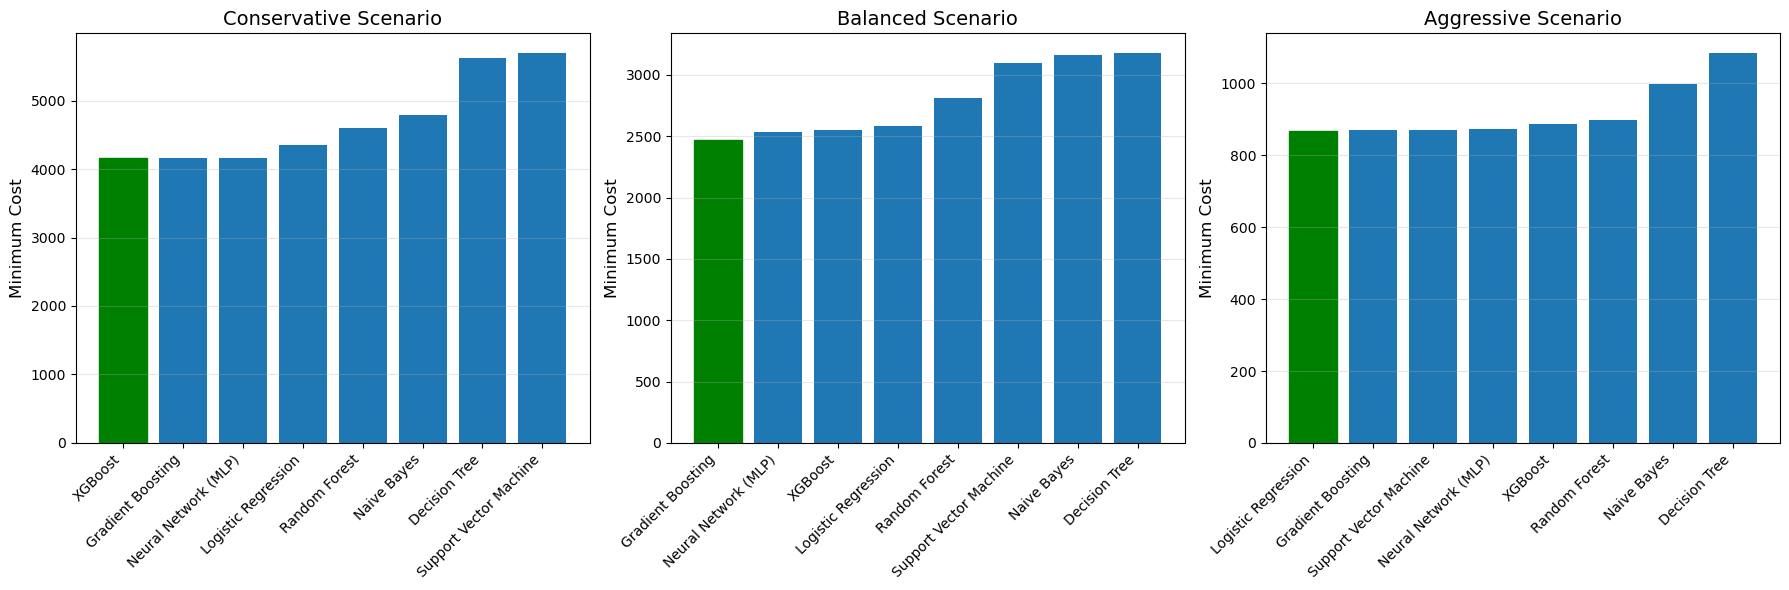

In [14]:
# Visualize cost comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (scenario_name, _, _) in enumerate(scenarios):
    ax = axes[idx]
    scenario_data = summary_df[summary_df['Scenario'] == scenario_name].sort_values('Min Cost')
    
    bars = ax.bar(range(len(scenario_data)), scenario_data['Min Cost'])
    ax.set_xticks(range(len(scenario_data)))
    ax.set_xticklabels(scenario_data['Model'], rotation=45, ha='right')
    ax.set_ylabel('Minimum Cost', fontsize=12)
    ax.set_title(f'{scenario_name} Scenario', fontsize=14)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Color best model differently
    min_idx = scenario_data['Min Cost'].idxmin()
    bars[0].set_color('green')
    
plt.tight_layout()
plt.show()

## 12. Precision-Recall Trade-off Analysis

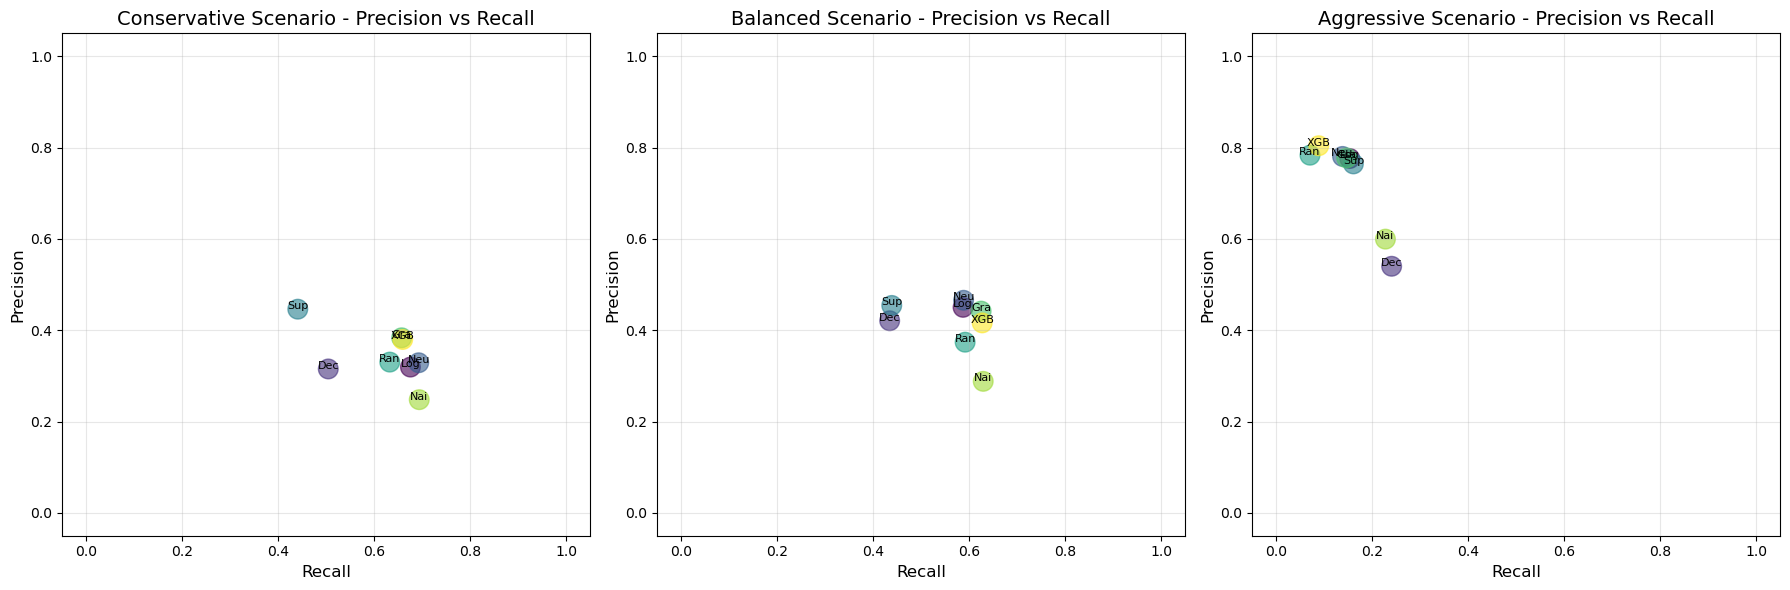

In [15]:
# Create precision-recall trade-off visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (scenario_name, _, _) in enumerate(scenarios):
    ax = axes[idx]
    scenario_data = summary_df[summary_df['Scenario'] == scenario_name]
    
    scatter = ax.scatter(scenario_data['Recall'], scenario_data['Precision'], 
                        s=200, alpha=0.6, c=range(len(scenario_data)), cmap='viridis')
    
    # Annotate points with model names
    for _, row in scenario_data.iterrows():
        ax.annotate(row['Model'][:3], (row['Recall'], row['Precision']), 
                   fontsize=8, ha='center')
    
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'{scenario_name} Scenario - Precision vs Recall', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

## 13. Cost vs AUC Analysis
Moro et al. mentioned AUC analysis not really following

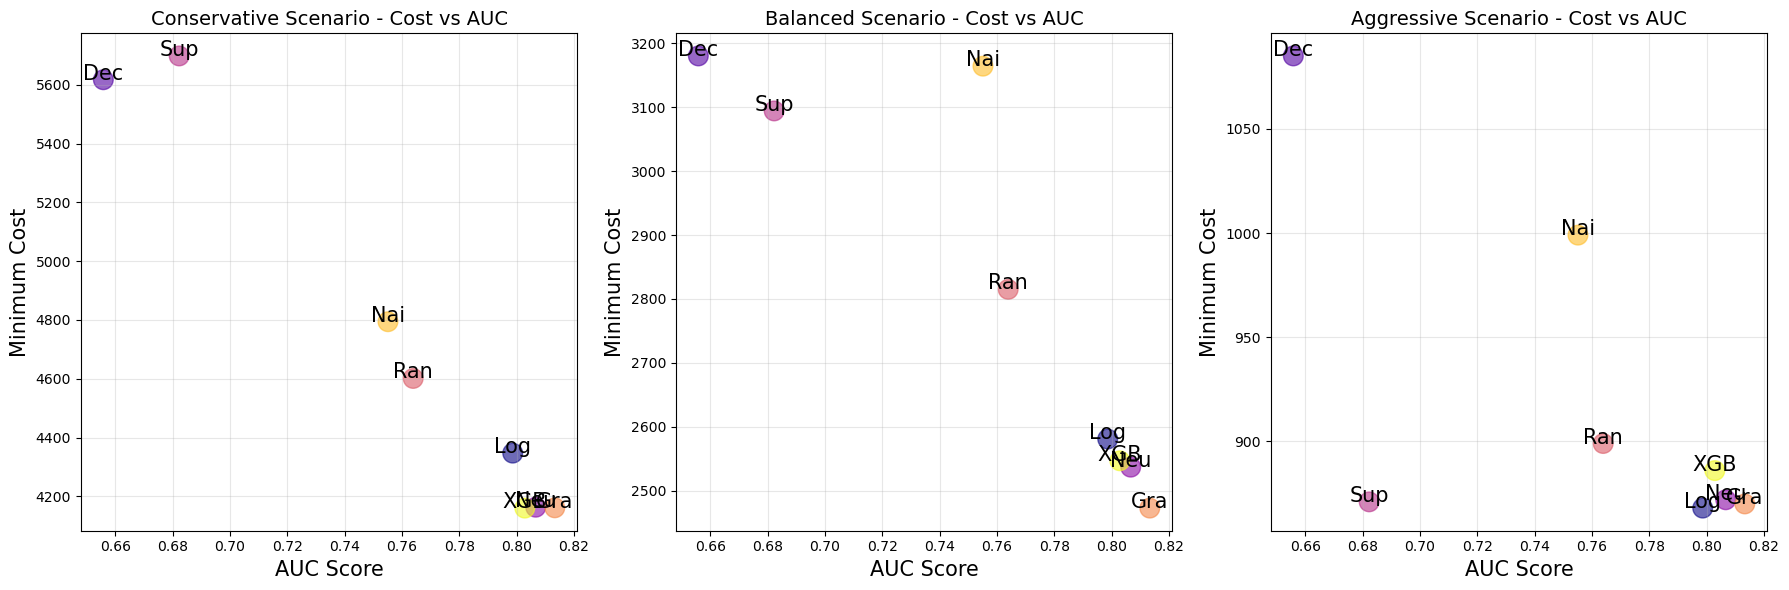

In [16]:
# Analyze relationship between AUC and minimum cost
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (scenario_name, _, _) in enumerate(scenarios):
    ax = axes[idx]
    scenario_data = summary_df[summary_df['Scenario'] == scenario_name].copy()
    
    # Add AUC scores
    scenario_data['AUC'] = scenario_data['Model'].map(auc_scores)
    
    scatter = ax.scatter(scenario_data['AUC'], scenario_data['Min Cost'], 
                        s=200, alpha=0.6, c=range(len(scenario_data)), cmap='plasma')
    
    # Annotate points
    for _, row in scenario_data.iterrows():
        ax.annotate(row['Model'][:3], (row['AUC'], row['Min Cost']), 
                   fontsize=15, ha='center')
    
    ax.set_xlabel('AUC Score', fontsize=15)
    ax.set_ylabel('Minimum Cost', fontsize=15)
    ax.set_title(f'{scenario_name} Scenario - Cost vs AUC', fontsize=14)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

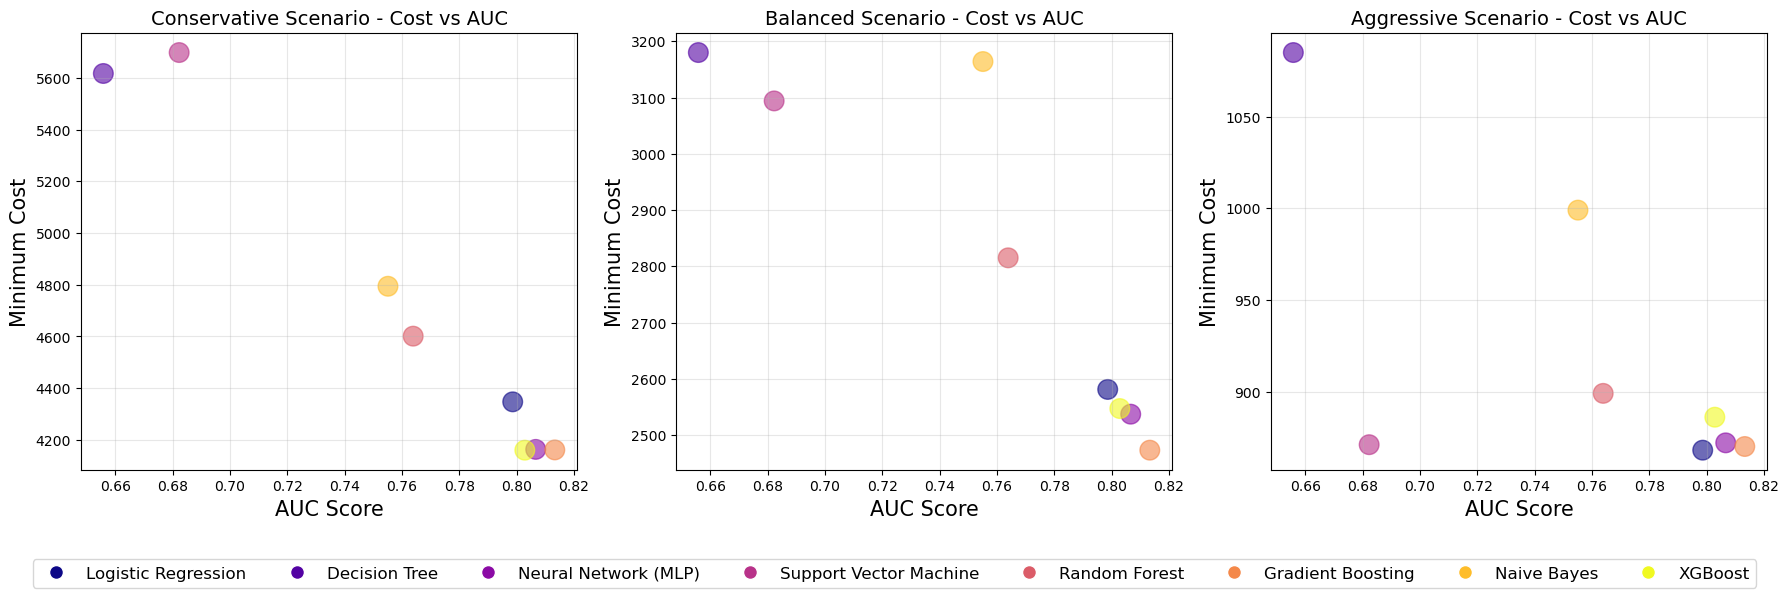

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

legend_elements = []

for idx, (scenario_name, _, _) in enumerate(scenarios):
    ax = axes[idx]
    scenario_data = summary_df[summary_df['Scenario'] == scenario_name].copy()

    # Add AUC scores
    scenario_data['AUC'] = scenario_data['Model'].map(auc_scores)

    scatter = ax.scatter(scenario_data['AUC'], scenario_data['Min Cost'], 
                         s=200, alpha=0.6, c=range(len(scenario_data)), cmap='plasma')
    
    # Store color info for legend
    for i, (_, row) in enumerate(scenario_data.iterrows()):
        color = scatter.to_rgba(i)
        label = row['Model']
        legend_elements.append((label, color))

    ax.set_xlabel('AUC Score', fontsize=15)
    ax.set_ylabel('Minimum Cost', fontsize=15)
    ax.set_title(f'{scenario_name} Scenario - Cost vs AUC', fontsize=14)
    ax.grid(True, alpha=0.3)

# Create a custom legend below all plots
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Remove duplicates while preserving order
seen = set()
legend_cleaned = []
for label, color in legend_elements:
    if label not in seen:
        seen.add(label)
        legend_cleaned.append(Line2D([0], [0], marker='o', color='w', label=label,
                                     markerfacecolor=color, markersize=10))

fig.legend(handles=legend_cleaned, loc='lower center', ncol=len(legend_cleaned), fontsize=12)
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Make space for legend at bottom
plt.show()


## 14. Final Model Recommendation
Moment of truth lots of additional stuff has been done, which model is the best, and why

In [26]:
# Create comprehensive comparison table
print("\nComprehensive Model Performance Summary")
print("="*80)

# Add AUC to summary
summary_df['AUC'] = summary_df['Model'].map(auc_scores)

# Display sorted by scenario and cost
for scenario_name, _, _ in scenarios:
    print(f"\n{scenario_name} Scenario:")
    scenario_data = summary_df[summary_df['Scenario'] == scenario_name].sort_values('Min Cost')
    print(scenario_data[['Model', 'Min Cost', 'Optimal Threshold', 'Precision', 'Recall', 'AUC']].to_string(index=False))

# Overall best model considering all scenarios
print("\n" + "="*80)
print("FINAL RECOMMENDATIONS:")
print("="*80)

# Calculate average rank across scenarios
model_ranks = {}
for model in models.keys():
    ranks = []
    for scenario_name, _, _ in scenarios:
        scenario_data = summary_df[summary_df['Scenario'] == scenario_name].sort_values('Min Cost')
        rank = scenario_data[scenario_data['Model'] == model].index[0] + 1
        ranks.append(rank)
    model_ranks[model] = np.mean(ranks)

# Sort by average rank
sorted_models = sorted(model_ranks.items(), key=lambda x: x[1])

print("\nModels ranked by average performance across all scenarios:")
for i, (model, avg_rank) in enumerate(sorted_models[:3], 1):
    print(f"{i}. {model} (Average Rank: {avg_rank:.2f})")


Comprehensive Model Performance Summary

Conservative Scenario:
                 Model  Min Cost  Optimal Threshold  Precision   Recall      AUC
               XGBoost      4160           0.101430   0.379653 0.659483 0.802883
     Gradient Boosting      4161           0.115726   0.383407 0.657328 0.813341
  Neural Network (MLP)      4163           0.096089   0.328732 0.692888 0.806682
   Logistic Regression      4347           0.115610   0.319246 0.675647 0.798656
         Random Forest      4601           0.105315   0.330146 0.632543 0.763936
           Naive Bayes      4794           0.000353   0.247883 0.693966 0.755142
         Decision Tree      5617           0.106383   0.315152 0.504310 0.655859
Support Vector Machine      5698           0.093132   0.446020 0.440733 0.682302

Balanced Scenario:
                 Model  Min Cost  Optimal Threshold  Precision   Recall      AUC
     Gradient Boosting      2473           0.156296   0.441736 0.625000 0.813341
  Neural Network (MLP)  

## 15. Cost Savings Analysis

In [19]:
# Calculate cost savings compared to default threshold (0.5)
print("\nCost Savings Analysis (compared to default 0.5 threshold)")
print("="*80)

for scenario_name, C_FP, C_FN in scenarios:
    print(f"\n{scenario_name} Scenario (C_FP={C_FP}, C_FN={C_FN}):")
    print("-"*60)
    
    for model_name, predictions in model_predictions.items():
        # Calculate cost at default threshold 0.5
        default_predictions = (predictions >= 0.5).astype(int)
        FP_default = np.sum((default_predictions == 1) & (y_test == 0))
        FN_default = np.sum((default_predictions == 0) & (y_test == 1))
        cost_default = C_FP * FP_default + C_FN * FN_default
        
        # Get optimized cost
        optimized_cost = cost_results[scenario_name][model_name]['min_cost']
        
        # Calculate savings
        savings = cost_default - optimized_cost
        savings_pct = (savings / cost_default) * 100 if cost_default > 0 else 0
        
        print(f"{model_name:25s}: Savings = {savings:6.0f} ({savings_pct:5.1f}%)")


Cost Savings Analysis (compared to default 0.5 threshold)

Conservative Scenario (C_FP=1, C_FN=10):
------------------------------------------------------------
Logistic Regression      : Savings =   3254 ( 42.8%)
Decision Tree            : Savings =    946 ( 14.4%)
Neural Network (MLP)     : Savings =   3158 ( 43.1%)
Support Vector Machine   : Savings =   1909 ( 25.1%)
Random Forest            : Savings =   2105 ( 31.4%)
Gradient Boosting        : Savings =   3130 ( 42.9%)
Naive Bayes              : Savings =   1366 ( 22.2%)
XGBoost                  : Savings =   2788 ( 40.1%)

Balanced Scenario (C_FP=1, C_FN=5):
------------------------------------------------------------
Logistic Regression      : Savings =   1255 ( 32.7%)
Decision Tree            : Savings =    263 (  7.6%)
Neural Network (MLP)     : Savings =   1169 ( 31.5%)
Support Vector Machine   : Savings =    748 ( 19.5%)
Random Forest            : Savings =    656 ( 18.9%)
Gradient Boosting        : Savings =   1223 ( 33.1%

## 16. Exporting the models
exporting the models to use in gradio ui later on, this step needs to be done once, can be removed later on

In [20]:
def export_top_models(model_objects, summary_df, export_dir='saved_models'):
    """
    Save top 3 models by average rank across all scenarios to .pkl files.

    Parameters:
    - model_objects (dict): Trained models with their names as keys.
    - summary_df (pd.DataFrame): Summary DataFrame including cost metrics.
    - export_dir (str): Directory to save models.
    """
    os.makedirs(export_dir, exist_ok=True)

    # Rank models by average performance across all scenarios
    model_ranks = {}
    for model in model_objects.keys():
        model_costs = summary_df[summary_df['Model'] == model]
        if not model_costs.empty:
            avg_rank = model_costs['Min Cost'].rank().mean()
            model_ranks[model] = avg_rank

    # Sort models by rank and select top 8
    top_models = sorted(model_ranks.items(), key=lambda x: x[1])[:8]

    for model_name, _ in top_models:
        model = model_objects[model_name]
        filename = f"{model_name.replace(' ', '_')}-v1.pkl"
        path = os.path.join(export_dir, filename)
        with open(path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Exported: {filename}")

In [21]:
# export_top_models(model_objects, summary_df)